<a href="https://colab.research.google.com/github/hug0-w/Tensor-Decompositions-OPM-MEG/blob/master/CP_Decomposition_Reward_Outcome_WINS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CP Decomposition of MEG Source-Space Power Data

Reward learning task — outcome-locked, mesial temporal + reward circuit ROIs

## 1. Setup

In [34]:
!pip install nilearn

In [35]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Feb 11 18:26:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   63C    P0             30W /   72W |     294MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [37]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=False)
path = '/content/drive/My Drive/OPM-MEG'
os.chdir(path)
print("Current Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/My Drive/OPM-MEG


In [38]:
!pip install tensorly

In [39]:
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_normalize
tl.set_backend('pytorch')
torch.set_default_dtype(torch.float32)

## 2. Load rank selection tools

In [40]:
%cd Tensor-Decompositions-OPM-MEG/
from src.tools.rankselection import rank_selection, run_parafac, r_squared
%cd ..

/content/drive/My Drive/OPM-MEG/Tensor-Decompositions-OPM-MEG
/content/drive/My Drive/OPM-MEG


## 3. Load data

In [63]:
mat_file = 'TFR_Outcome_ROI_WinV2.mat'

with h5py.File(mat_file, 'r') as f:
    #tensor = np.array(f['TFR_full'])
    tensor_norm = np.array(f['pow_norm'])
    time_vec = np.array(f['time_vec']).flatten()
    freq_vec = np.array(f['freq_vec']).flatten()
    roi_labels = [''.join(chr(c) for c in f[ref][:].flatten()) for ref in f['roi_labels'][:].flatten()]

#print(f"Tensor shape (raw): {tensor.shape}")
print(f"Tensor shape (normalized): {tensor_norm.shape}")
print(f"Time: {time_vec[0]*1000:.0f} to {time_vec[-1]*1000:.0f} ms ({len(time_vec)} points)")
print(f"Freq: {freq_vec[0]:.0f} to {freq_vec[-1]:.0f} Hz ({len(freq_vec)} points)")
print(f"ROIs: {len(roi_labels)}")

Tensor shape (normalized): (101, 66, 120)
Time: 0 to 1000 ms (101 points)
Freq: 5 to 70 Hz (66 points)
ROIs: 120


In [64]:
pow_norm = tensor_norm.copy()
pow_norm = pow_norm.T

In [43]:
#pow_norm = np.delete(pow_norm, 0, axis=1)

In [44]:
#freq_vec = np.delete(freq_vec, 0)

## 4. Load AAL2 labels

In [ ]:
%cd

In [65]:
def load_aal2_labels(txt_path, n_rois=None):
    labels = []
    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) >= 2:
                labels.append(parts[1])
    if n_rois is not None and n_rois < len(labels):
        print(f"Truncating labels from {len(labels)} to {n_rois}")
        labels = labels[:n_rois]
    print(f"Loaded {len(labels)} AAL2 labels")
    return labels

aal2_full = load_aal2_labels('aal2.nii.txt')
aal_nifti_path = 'aal2.nii'
print(len(aal2_full))

Loaded 120 AAL2 labels
120


## 5. Filter ROIs — mesial temporal + reward outcome circuit

In [66]:
keep_patterns = [
    'amygdala',           # outcome valence encoding
    'hippocampus',        # contextual reward memory
    'parahippocampal',    # contextual associations
    'cingulate_ant',      # prediction error, outcome monitoring
    'insula',             # loss processing, outcome salience
    'ofc',                # value updating at outcome
    'frontal_med_orb',    # vmPFC - outcome evaluation
  #  'caudate',            # reward prediction error signal
]

keep_idx = [i for i, name in enumerate(aal2_full)
            if any(pattern in name.lower() for pattern in keep_patterns)]

pow_norm_filtered = pow_norm[keep_idx, :, :]
labels_filtered = [aal2_full[i] for i in keep_idx]

print(f"Kept {len(keep_idx)} / {len(aal2_full)} ROIs")
print(f"New shape: {pow_norm_filtered.shape}")
print(f"ROIs kept: {labels_filtered}")

Kept 20 / 120 ROIs
New shape: (20, 66, 101)
ROIs kept: ['Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'OFCmed_L', 'OFCmed_R', 'OFCant_L', 'OFCant_R', 'OFCpost_L', 'OFCpost_R', 'OFClat_L', 'OFClat_R', 'Insula_L', 'Insula_R', 'Cingulate_Ant_L', 'Cingulate_Ant_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R']


## 6. ERS / ERD split

In [67]:
pow_positive = np.maximum(pow_norm_filtered, 0)   # ERS
pow_negative = np.abs(np.minimum(pow_norm_filtered, 0))  # ERD (flipped positive)

print(f"ERS non-zero: {(pow_positive > 0).mean()*100:.1f}%")
print(f"ERD non-zero: {(pow_negative > 0).mean()*100:.1f}%")

ERS non-zero: 38.7%
ERD non-zero: 61.3%


## 7. Quick TFR sanity check

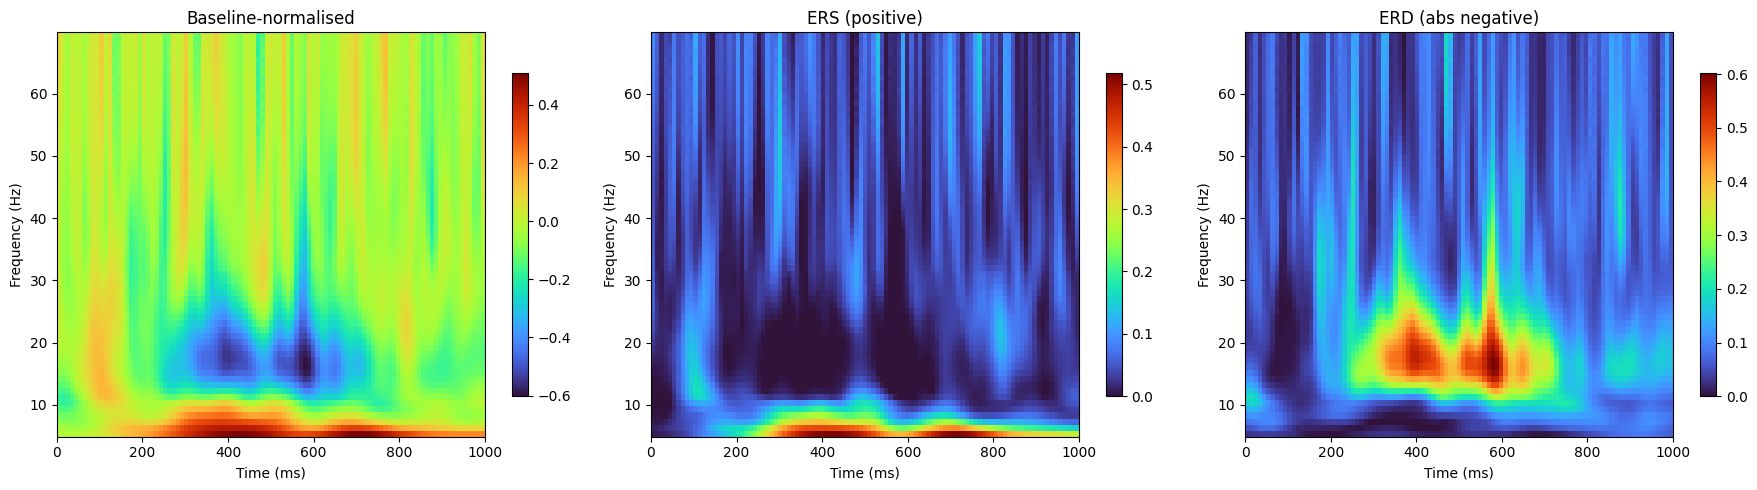

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, title in zip(axes,
    [pow_norm_filtered, pow_positive, pow_negative],
    ['Baseline-normalised', 'ERS (positive)', 'ERD (abs negative)']):
    avg = np.nanmean(data, axis=0)
    im = ax.imshow(avg, aspect='auto', origin='lower',
                   extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],
                   cmap='turbo')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

## 8. Histogram of values

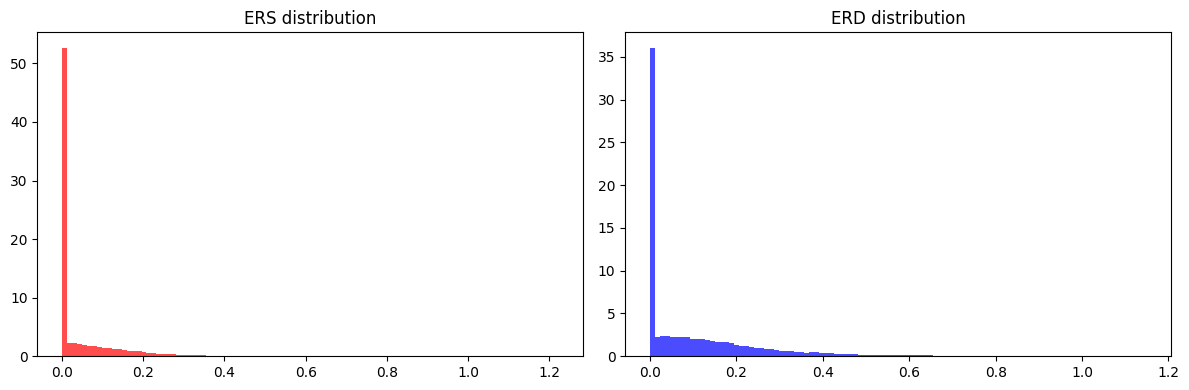

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(pow_positive.ravel(), bins=100, density=True, color='red', alpha=0.7)
axes[0].set_title('ERS distribution')
axes[1].hist(pow_negative.ravel(), bins=100, density=True, color='blue', alpha=0.7)
axes[1].set_title('ERD distribution')
plt.tight_layout()
plt.show()

## 9. Convert to torch and move to GPU

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

pos_pow_torch = torch.as_tensor(pow_positive, device=device, dtype=torch.float32)
neg_pow_torch = torch.as_tensor(pow_negative, device=device, dtype=torch.float32)

print(f"ERS tensor shape: {pos_pow_torch.shape}")
print(f"ERD tensor shape: {neg_pow_torch.shape}")

Using device: cuda
ERS tensor shape: torch.Size([20, 66, 101])
ERD tensor shape: torch.Size([20, 66, 101])


## 10. Rank selection — ERS

In [72]:
results_ers = rank_selection(pos_pow_torch, ranks=range(1, 10), n_repeats=30)


=== Rank 1 ===
--- Testing Rank 1 with 30 repeats ---
  30 models converged
  Rank 1: Best Error=0.6795 | Best R²=0.4334
  Mean Stability=1.0000 ± 0.0000

=== Rank 2 ===
--- Testing Rank 2 with 30 repeats ---
  30 models converged
  Rank 2: Best Error=0.6237 | Best R²=0.5226
  Mean Stability=0.9997 ± 0.0003

=== Rank 3 ===
--- Testing Rank 3 with 30 repeats ---
  30 models converged
  Rank 3: Best Error=0.5795 | Best R²=0.5879
  Mean Stability=0.9954 ± 0.0031

=== Rank 4 ===
--- Testing Rank 4 with 30 repeats ---
  30 models converged
  Rank 4: Best Error=0.5412 | Best R²=0.6406
  Mean Stability=0.5297 ± 0.3022

=== Rank 5 ===
--- Testing Rank 5 with 30 repeats ---
  30 models converged
  Rank 5: Best Error=0.5031 | Best R²=0.6894
  Mean Stability=0.9459 ± 0.1939

=== Rank 6 ===
--- Testing Rank 6 with 30 repeats ---
  30 models converged
  Rank 6: Best Error=0.4803 | Best R²=0.7169
  Mean Stability=0.7404 ± 0.3567

=== Rank 7 ===
--- Testing Rank 7 with 30 repeats ---
  30 models con

In [73]:
stabilities_ers = results_ers['mean_stabilities']
stds_ers = results_ers['std_stabilities']
ranks_ers = results_ers['ranks']
r2_scores = results_ers['best_r2']


## 11. Plot rank selection — ERS

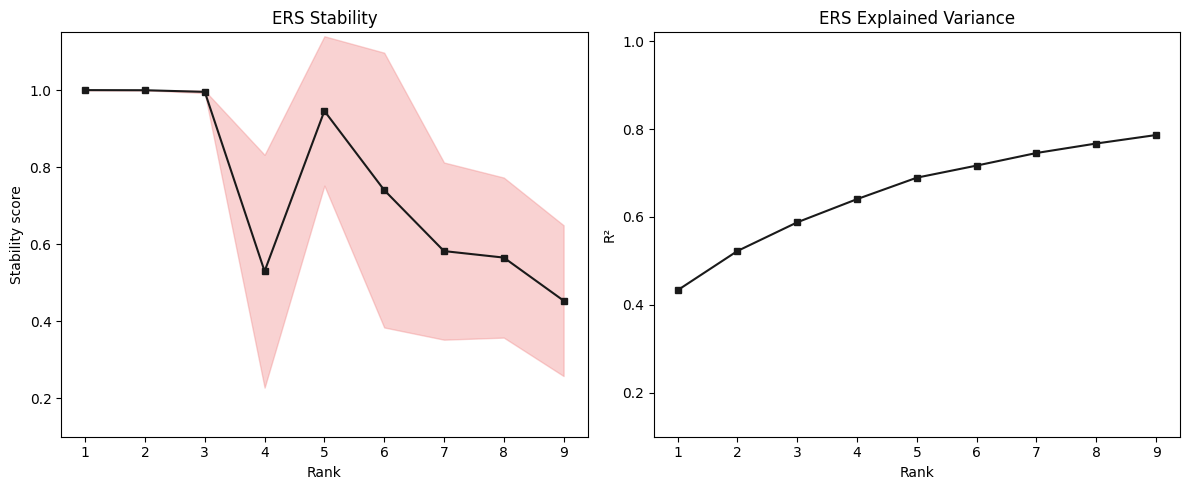

In [74]:
def plot_rank_selection(ranks, stabilities, stab_stds, r2_scores, title_prefix=''):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Stability
    ax = axes[0]
    y = np.asarray(stabilities)
    yerr = np.asarray(stab_stds)
    ax.fill_between(ranks, y - yerr, y + yerr, color='lightcoral', alpha=0.35)
    ax.plot(ranks, y, 's-', color='0.1', markersize=4)
    ax.set_title(f'{title_prefix} Stability')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Stability score')
    ax.set_xticks(ranks)
    ax.set_ylim(0.1, 1.15)

    # R²
    ax = axes[1]
    y = np.asarray(r2_scores)
    ax.plot(ranks, y, 's-', color='0.1', markersize=4)
    ax.set_title(f'{title_prefix} Explained Variance')
    ax.set_xlabel('Rank')
    ax.set_ylabel('R²')
    ax.set_xticks(ranks)
    ax.set_ylim(0.1, 1.02)

    plt.tight_layout()
    plt.show()

plot_rank_selection(ranks_ers, stabilities_ers, stds_ers, r2_scores, 'ERS')

## 12. Rank selection — ERD

In [88]:
results_erd = rank_selection(neg_pow_torch, ranks=range(1, 10), n_repeats=30)


=== Rank 1 ===
--- Testing Rank 1 with 30 repeats ---
  30 models converged
  Rank 1: Best Error=0.5978 | Best R²=0.4503
  Mean Stability=1.0000 ± 0.0000

=== Rank 2 ===
--- Testing Rank 2 with 30 repeats ---
  30 models converged
  Rank 2: Best Error=0.5467 | Best R²=0.5403
  Mean Stability=0.9985 ± 0.0007

=== Rank 3 ===
--- Testing Rank 3 with 30 repeats ---
  30 models converged
  Rank 3: Best Error=0.5105 | Best R²=0.5992
  Mean Stability=0.7491 ± 0.2439

=== Rank 4 ===
--- Testing Rank 4 with 30 repeats ---
  30 models converged
  Rank 4: Best Error=0.4805 | Best R²=0.6448
  Mean Stability=0.5541 ± 0.2818

=== Rank 5 ===
--- Testing Rank 5 with 30 repeats ---
  30 models converged
  Rank 5: Best Error=0.4509 | Best R²=0.6873
  Mean Stability=0.4308 ± 0.2172

=== Rank 6 ===
--- Testing Rank 6 with 30 repeats ---
  30 models converged
  Rank 6: Best Error=0.4245 | Best R²=0.7228
  Mean Stability=0.9293 ± 0.1600

=== Rank 7 ===
--- Testing Rank 7 with 30 repeats ---
  30 models con

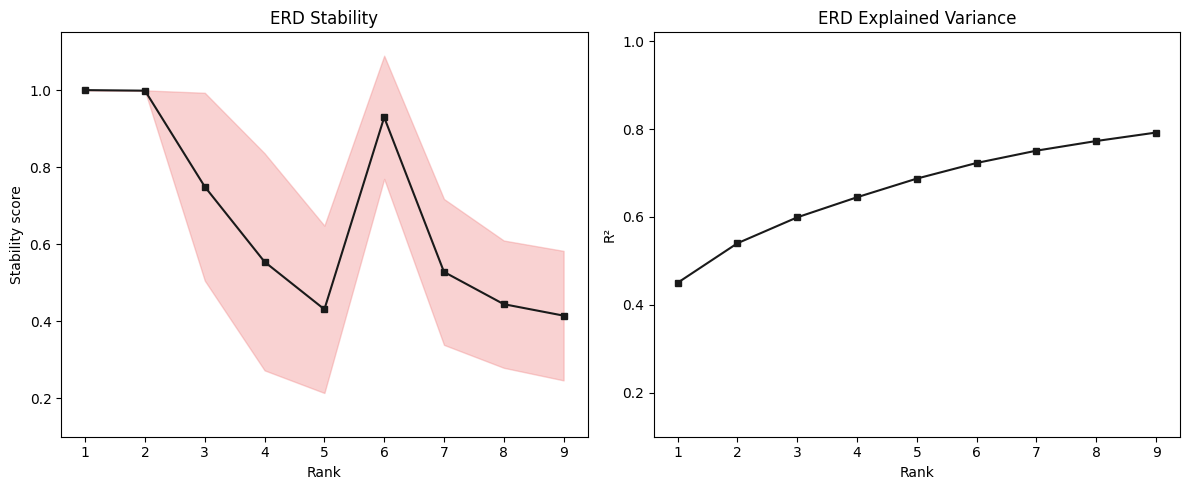

In [89]:
stabilities_erd = results_erd['mean_stabilities']
stds_erd = results_erd['std_stabilities']
ranks_erd = results_erd['ranks']
r2_scores = results_erd['best_r2']


plot_rank_selection(ranks_erd, stabilities_erd, stds_erd, r2_scores, 'ERD')

## 13. Choose ranks and run final decomposition


In [85]:
RANK_ERS = 7
RANK_ERD =  7

print(f"Using ERS rank: {RANK_ERS}")
print(f"Using ERD rank: {RANK_ERD}")

Using ERS rank: 7
Using ERD rank: 7


In [86]:
# Final ERS decomposition
cp_tensor_ers = parafac(
    pos_pow_torch,
    rank=RANK_ERS,
    n_iter_max=10000,
    init='svd',
    tol=1e-10,
    normalize_factors=True,
    linesearch=True
)
weights_ers, factors_ers = cp_tensor_ers

# Final ERD decomposition
cp_tensor_erd = parafac(
    neg_pow_torch,
    rank=RANK_ERD,
    n_iter_max=10000,
    init='svd',
    tol=1e-10,
    normalize_factors=True,
    linesearch=True
)
weights_erd, factors_erd = cp_tensor_erd

print(f"ERS R²: {r_squared(pos_pow_torch, cp_tensor_ers):.4f}")
print(f"ERD R²: {r_squared(neg_pow_torch, cp_tensor_erd):.4f}")

ERS R²: 0.7449
ERD R²: 0.7501


## 14. Extract and sort factors by weight (descending)

In [82]:
def extract_sorted_factors(weights, factors):
    w = weights.to('cpu').numpy().copy()
    args = np.argsort(w)[::-1]  # descending
    fs = [f.to('cpu').numpy().copy() for f in factors]
    A, B, C = fs
    return A[:, args], B[:, args], C[:, args]

A_ers, B_ers, C_ers = extract_sorted_factors(weights_ers, factors_ers)
A_erd, B_erd, C_erd = extract_sorted_factors(weights_erd, factors_erd)

print(f"ERS factors: A={A_ers.shape}, B={B_ers.shape}, C={C_ers.shape}")
print(f"ERD factors: A={A_erd.shape}, B={B_erd.shape}, C={C_erd.shape}")

ERS factors: A=(20, 7), B=(66, 7), C=(101, 7)
ERD factors: A=(20, 5), B=(66, 5), C=(101, 5)


## 15. Plotting function

In [83]:
def to_numpy(x):
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    elif hasattr(x, "numpy"):
        return x.numpy()
    return np.array(x)

def plot_factors_on_atlas(
    A, B, C,
    roi_labels, full_atlas_labels, aal_nifti_path,
    freq_vec=None, time_vec=None,
    top_n_rois=5,
    threshold_percentile=80,
    plot_type='ERS',
    time_in_seconds=True,
    save_fig=False,
    filename=None
):
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)

    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]
    main_color = 'red' if plot_type == 'ERS' else 'blue'
    cmap = 'Reds' if plot_type == 'ERS' else 'Blues'

    if freq_vec is None:
        freq_vec = np.linspace(0, 45, B.shape[0])
    else:
        freq_vec = to_numpy(freq_vec)

    if time_vec is None:
        time_vec = np.linspace(0, 1000, C.shape[0])
    else:
        time_vec = to_numpy(time_vec)
        if time_in_seconds:
            time_vec = time_vec * 1000

    for r in range(R):
        fig = plt.figure(figsize=(18, 8))
        gs = GridSpec(2, 4, figure=fig,
                      height_ratios=[1, 0.8],
                      width_ratios=[1.2, 1, 1, 1],
                      hspace=0.3, wspace=0.3)

        title_color = 'red' if plot_type == 'ERS' else 'blue'
        fig.suptitle(f"{plot_type} Component {r+1}", fontsize=16,
                     fontweight="bold", color=title_color)

        # --- Spatial weights ---
        roi_weights = np.nan_to_num(A[:, r].copy(), nan=0.0)
        abs_weights = np.abs(roi_weights)
        max_abs = np.max(abs_weights)
        roi_weights_norm = abs_weights / max_abs if max_abs > 0 else abs_weights

        brain_vol = np.zeros(aal_data.shape, dtype=float)
        for i, roi_name in enumerate(roi_labels):
            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                brain_vol[aal_data == atlas_idx + 1] = roi_weights_norm[i]
            except ValueError:
                pass

        weight_nii = nib.Nifti1Image(brain_vol, affine)
        nonzero = roi_weights_norm[roi_weights_norm != 0]
        threshold = np.percentile(nonzero, threshold_percentile) if len(nonzero) > 0 else 0.01

        # Glass brain
        ax_glass = fig.add_subplot(gs[0, 0])
        plotting.plot_glass_brain(
            weight_nii, axes=ax_glass, display_mode="lyrz",
            threshold=threshold, colorbar=True, plot_abs=True,
            vmax=1.0, cmap=cmap, alpha=0.8)
        ax_glass.set_title(f"Glass Brain ({plot_type})")

        # Axial slices
        ax_stat = fig.add_subplot(gs[0, 1:])
        plotting.plot_stat_map(
            weight_nii, axes=ax_stat, display_mode="z",
            cut_coords=7, threshold=threshold,
            colorbar=True, vmax=1.0, cmap=cmap)

        # Top ROIs bar chart
        ax_bar = fig.add_subplot(gs[1, 0])
        sorted_idx = np.argsort(abs_weights)[::-1]
        top_idx = sorted_idx[:top_n_rois]
        top_weights = abs_weights[top_idx]
        top_names = [roi_labels[i][:20] for i in top_idx]
        y_pos = np.arange(len(top_weights))
        ax_bar.barh(y_pos, top_weights, color=main_color, alpha=0.7, edgecolor="black")
        ax_bar.set_yticks(y_pos)
        ax_bar.set_yticklabels(top_names, fontsize=9)
        ax_bar.set_title(f"Top {top_n_rois} {plot_type} ROIs")
        ax_bar.invert_yaxis()

        # Frequency profile
        ax_freq = fig.add_subplot(gs[1, 1:3])
        freq_weights = np.abs(B[:, r])
        ax_freq.fill_between(freq_vec, freq_weights, alpha=0.3, color=main_color)
        ax_freq.plot(freq_vec, freq_weights, linewidth=2, color=main_color)
        ax_freq.set_title(f"{plot_type} Frequency Profile")
        ax_freq.set_xlabel("Frequency (Hz)")

        bands = {'\u03b8': (4, 8), '\u03b1': (8, 13), '\u03b2': (13, 30), '\u03b3': (30, 45)}
        for band_name, (f_low, f_high) in bands.items():
            f_mid = (f_low + f_high) / 2
            if freq_vec.min() <= f_mid <= freq_vec.max():
                ax_freq.axvspan(f_low, f_high, alpha=0.1, color='gray')
                ax_freq.text(f_mid, ax_freq.get_ylim()[1] * 0.95, band_name,
                             ha='center', fontsize=8, alpha=0.7)

        # Temporal profile
        ax_time = fig.add_subplot(gs[1, 3])
        time_weights = np.abs(C[:, r])
        ax_time.fill_between(time_vec, time_weights, alpha=0.3, color=main_color)
        ax_time.plot(time_vec, time_weights, linewidth=1.5, color=main_color)
        ax_time.set_title(f"{plot_type} Temporal Profile")
        ax_time.set_xlabel("Time (ms)")

        plt.tight_layout()

        if save_fig and filename:
            plt.savefig(filename + f'_Component_{r+1}.svg')

        plt.show()

## 16. Plot ERS components

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


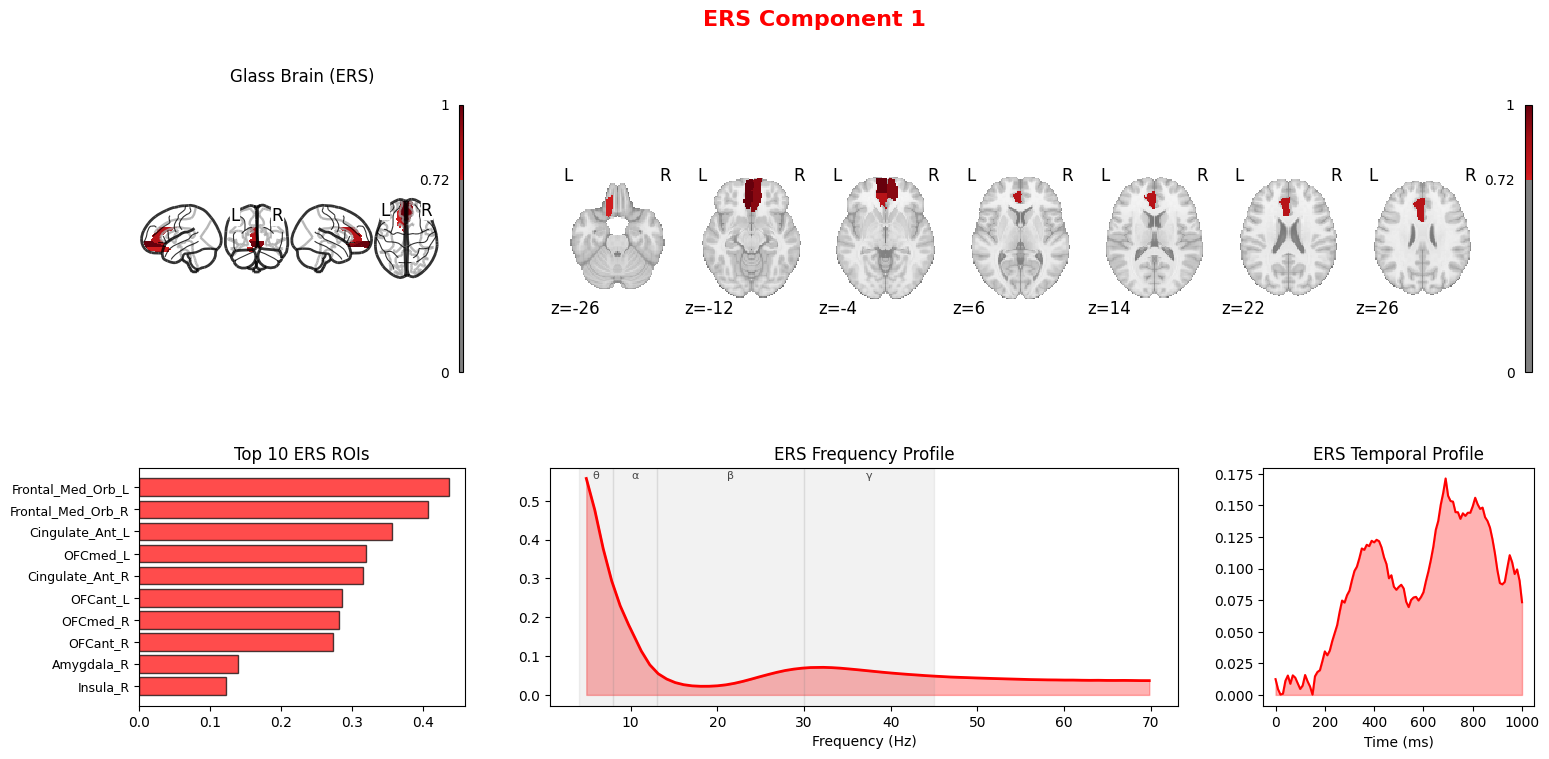

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


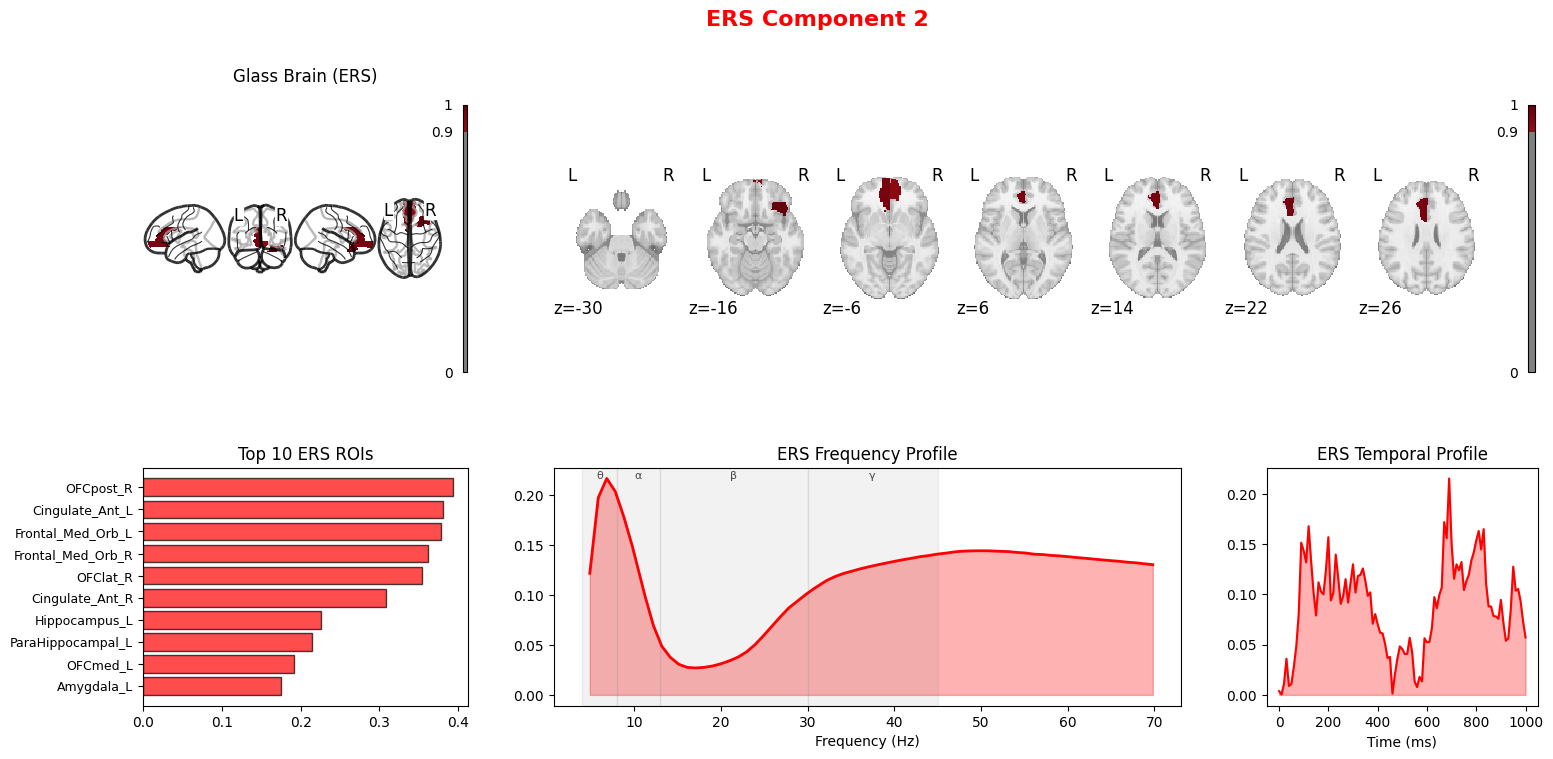

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


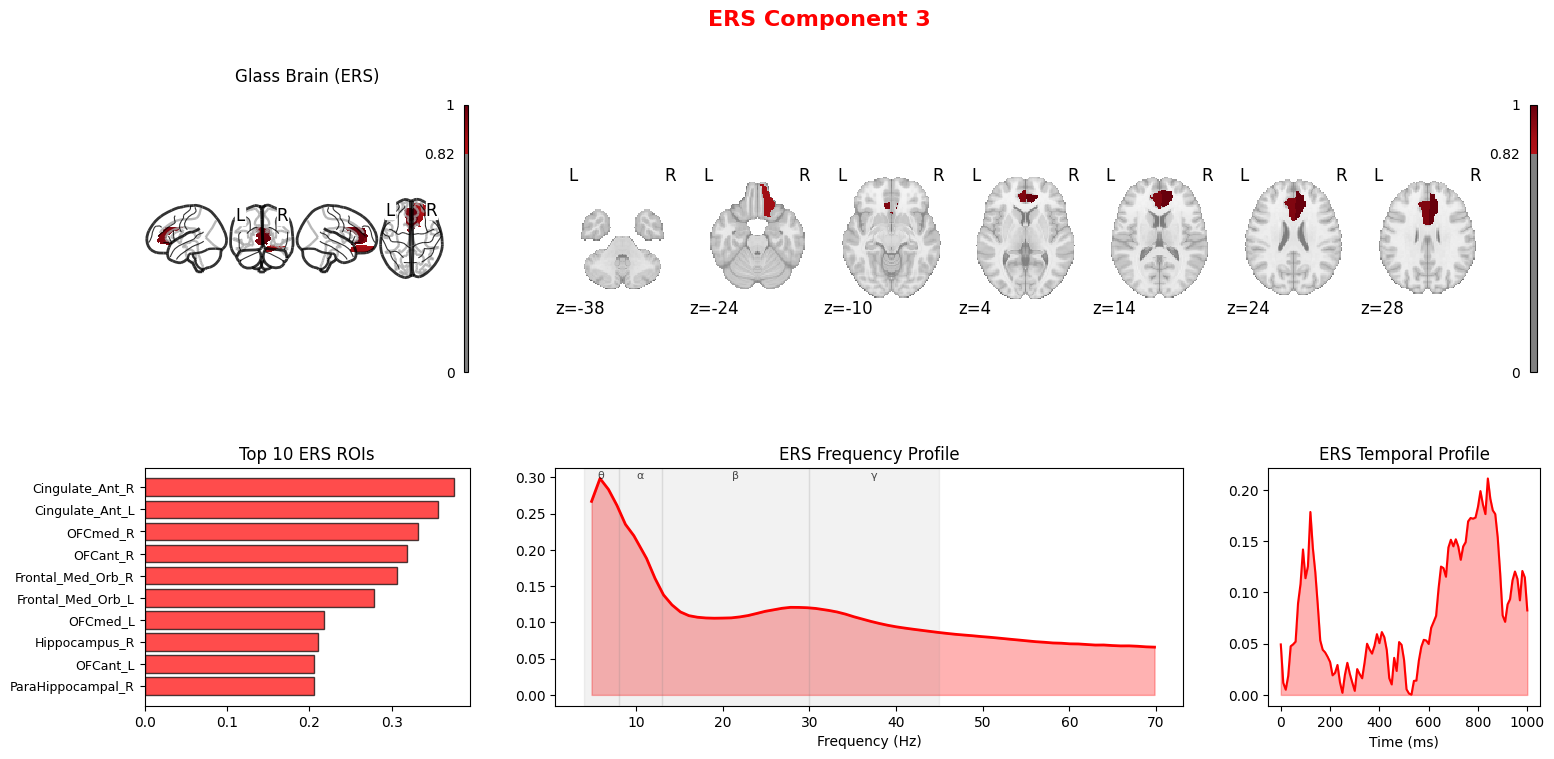

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


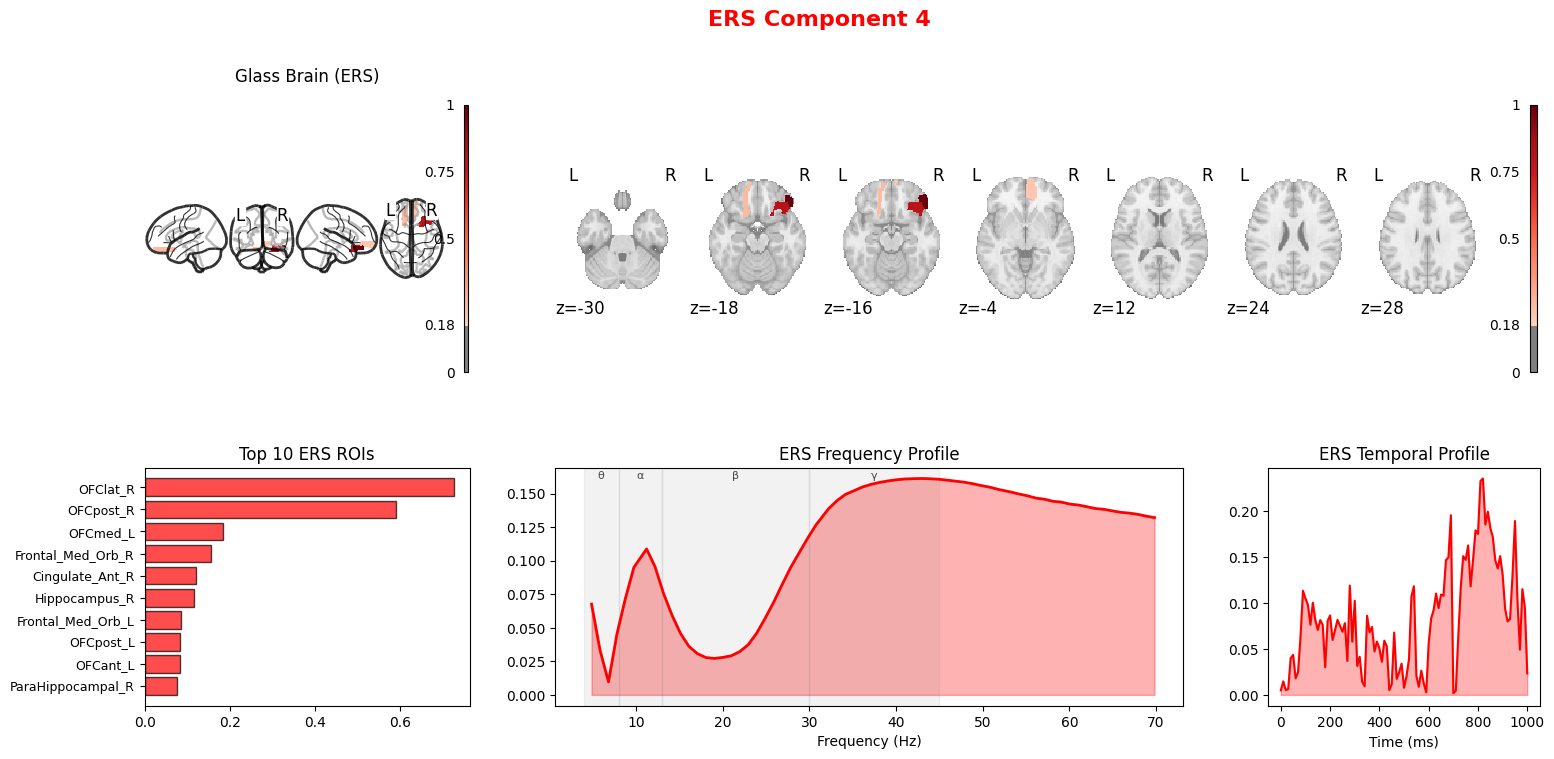

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


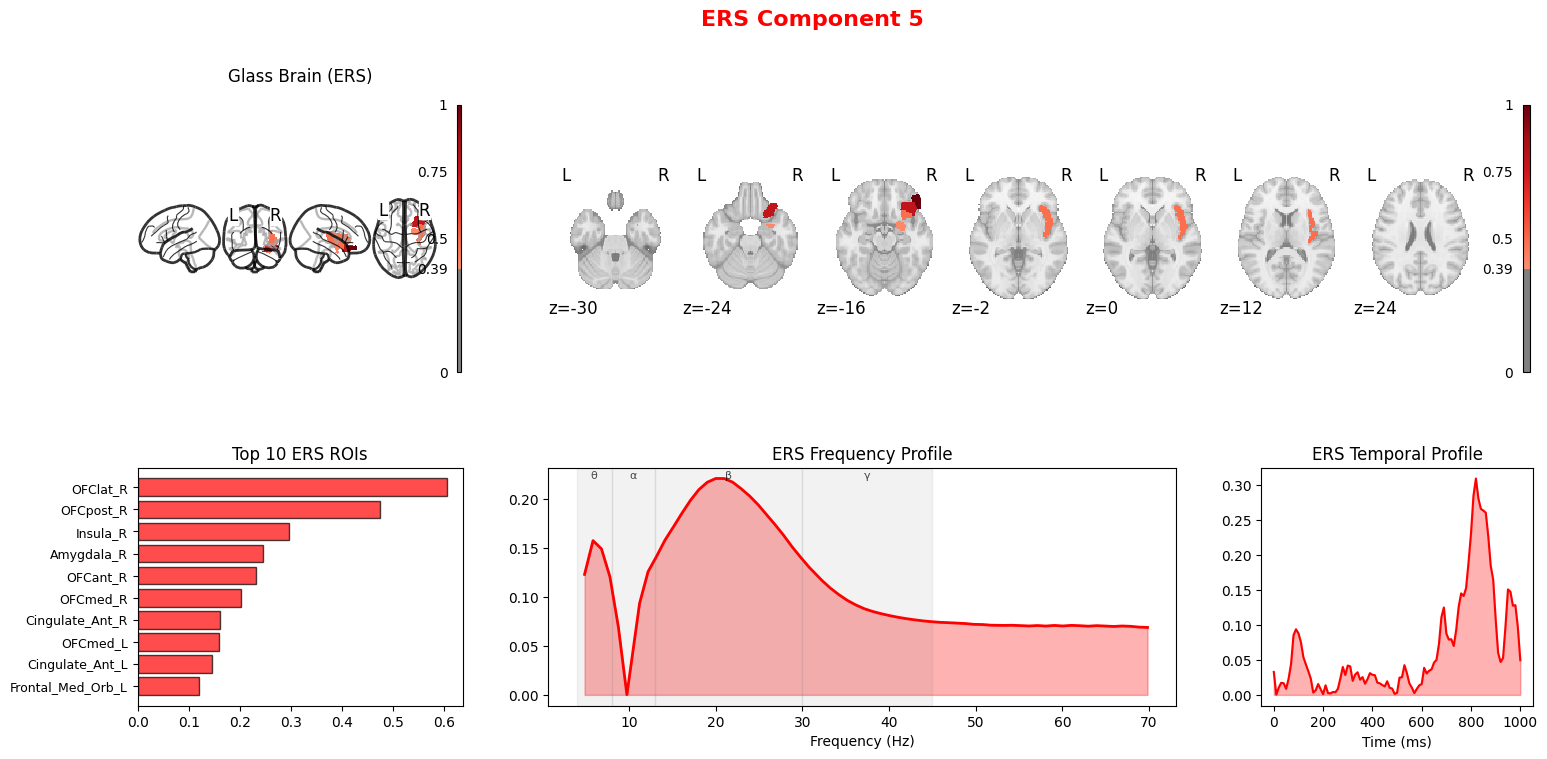

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


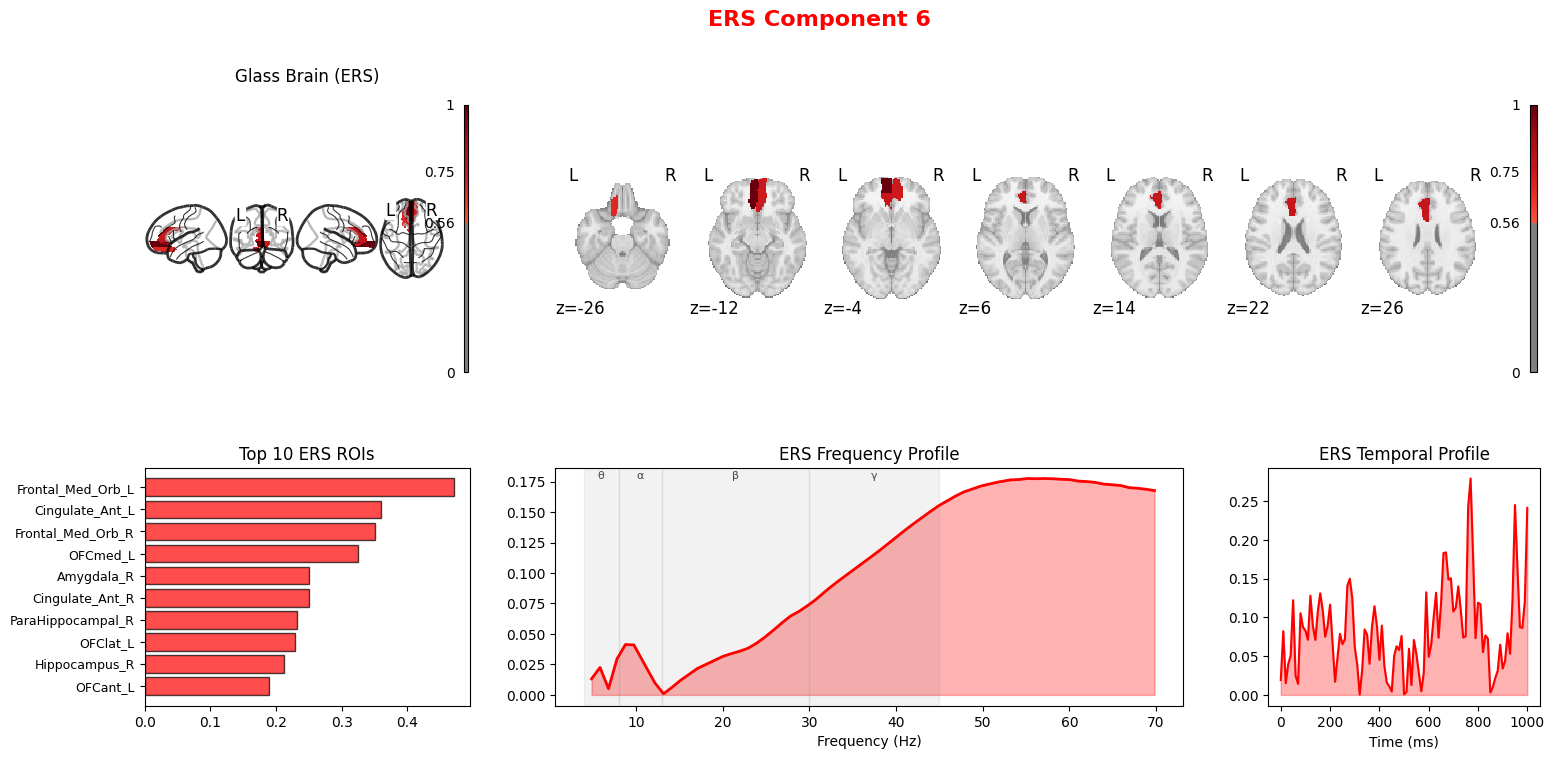

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


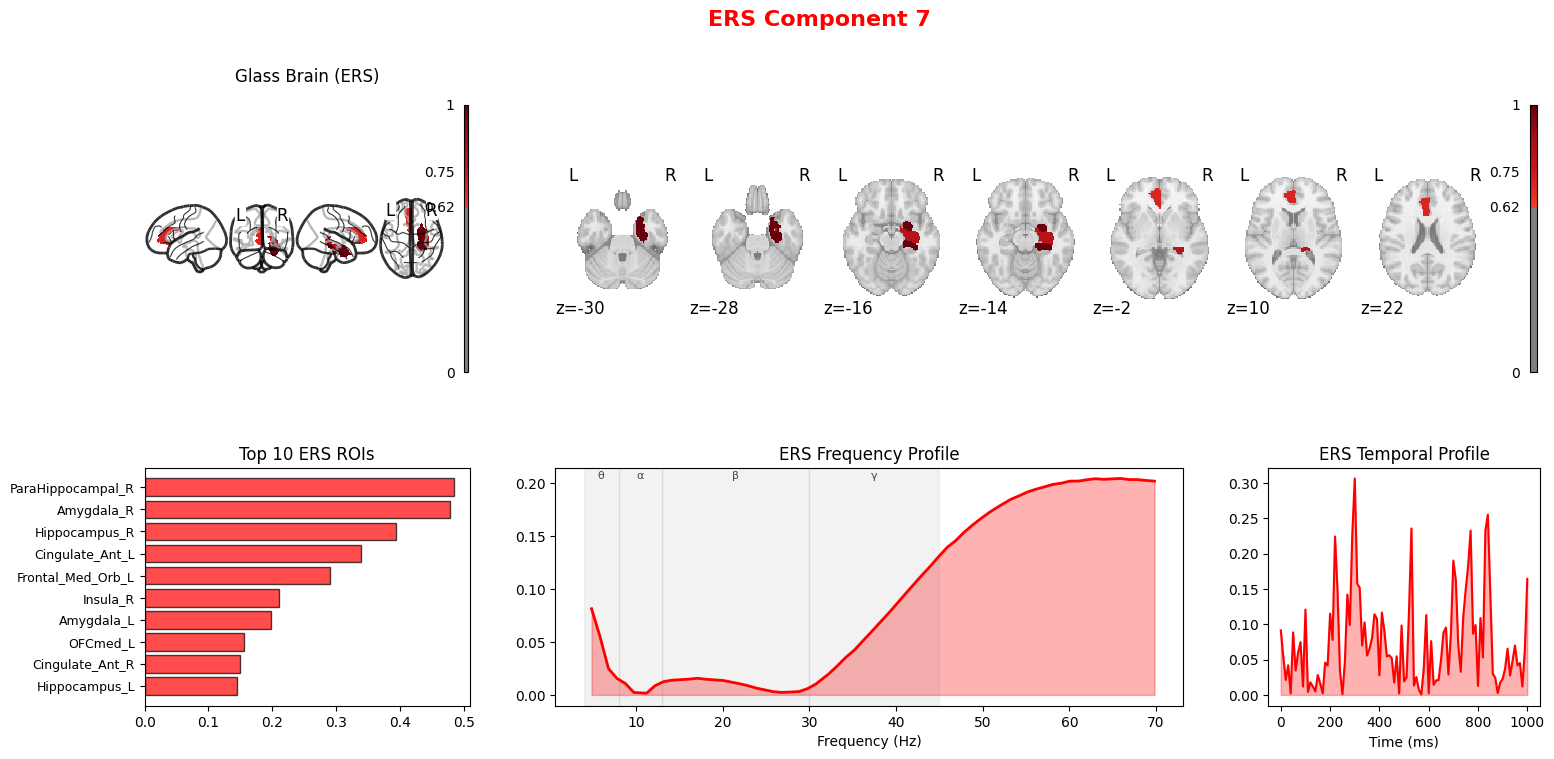

In [84]:
plot_factors_on_atlas(
    A_ers, B_ers, C_ers,
    labels_filtered, aal2_full, aal_nifti_path,
    freq_vec=freq_vec, time_vec=time_vec,
    top_n_rois=10,
    plot_type='ERS',
    save_fig=False,
    filename='ERS'
)

## 17. Plot ERD components

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


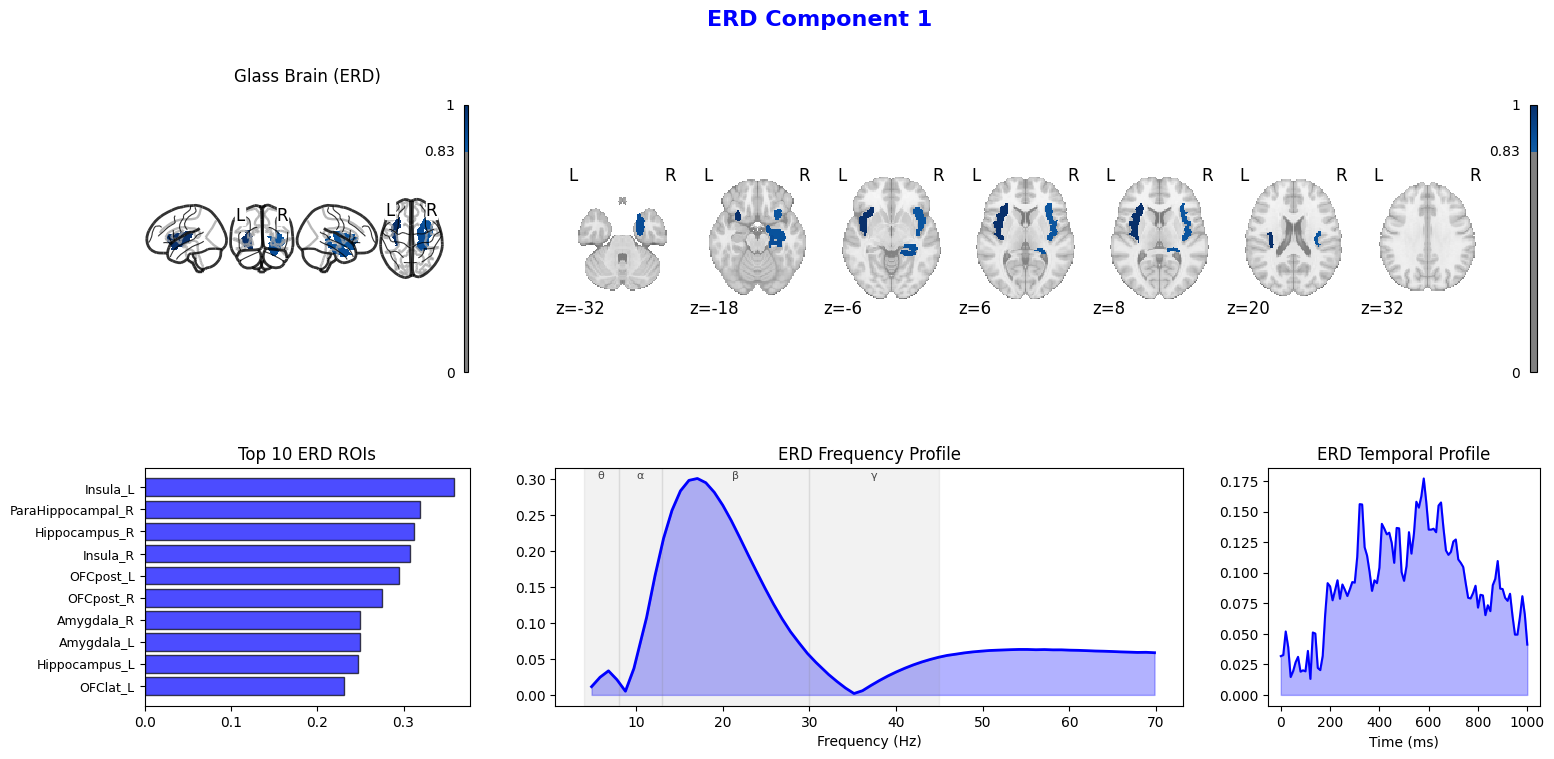

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


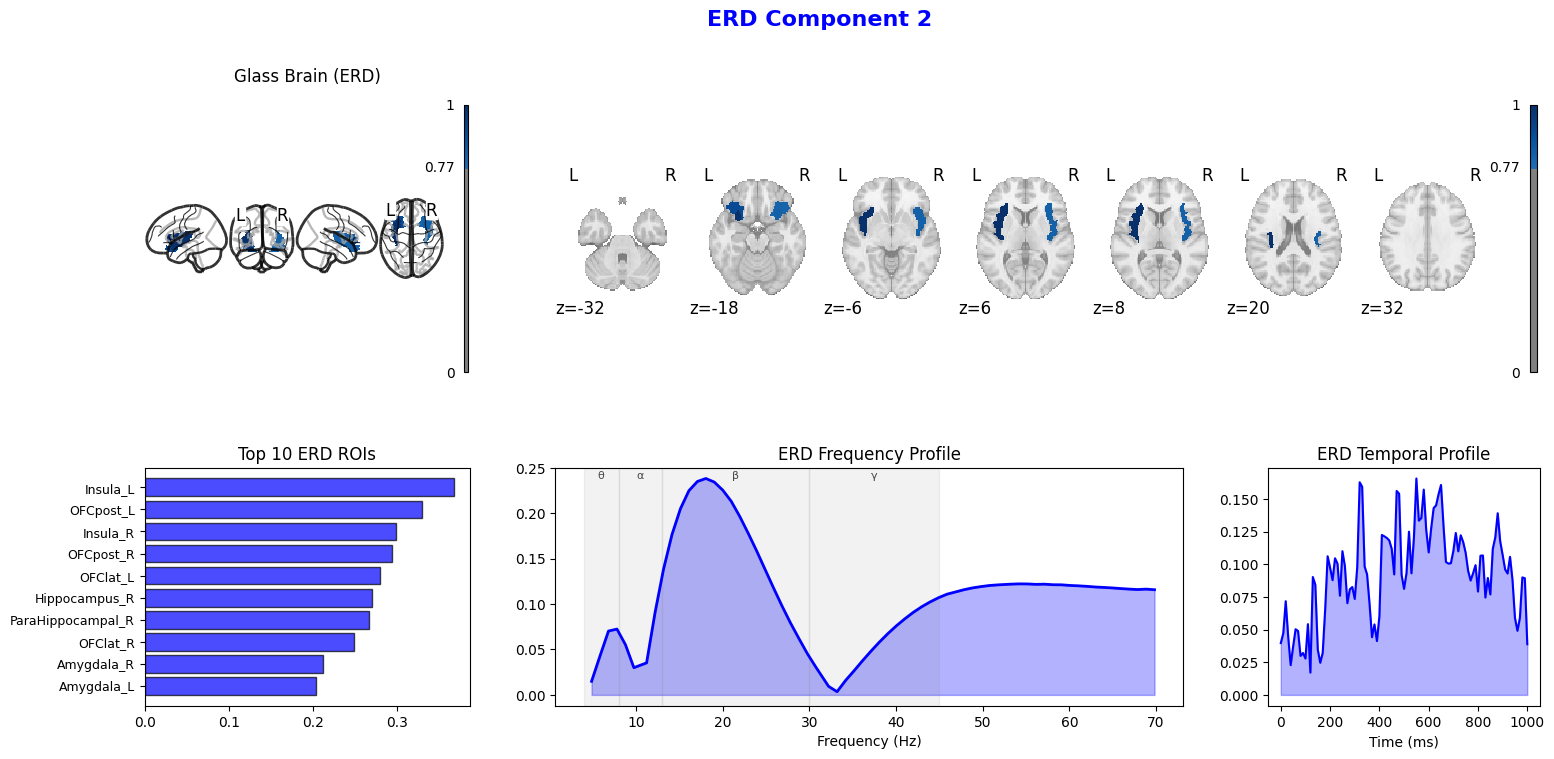

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


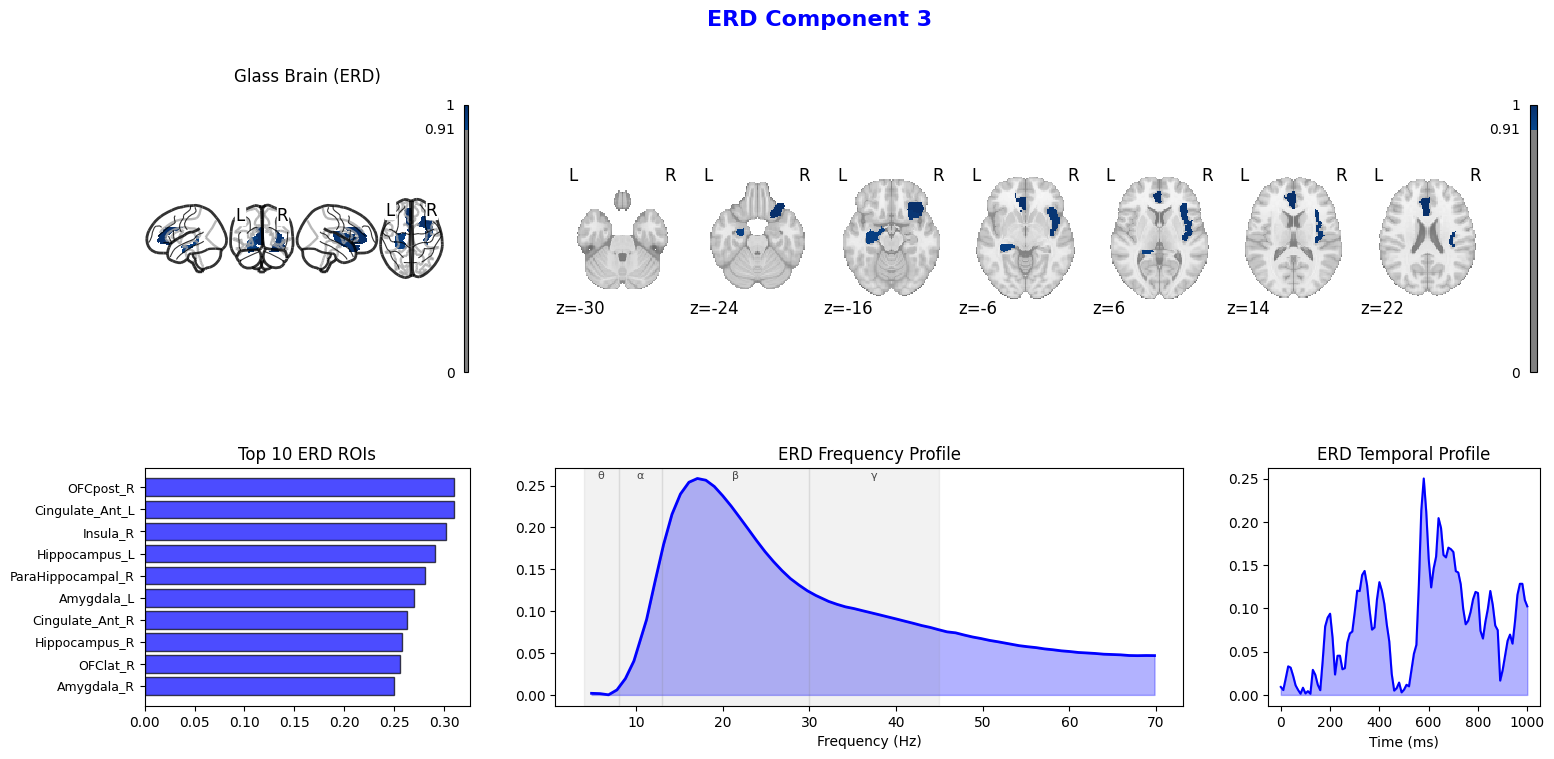

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


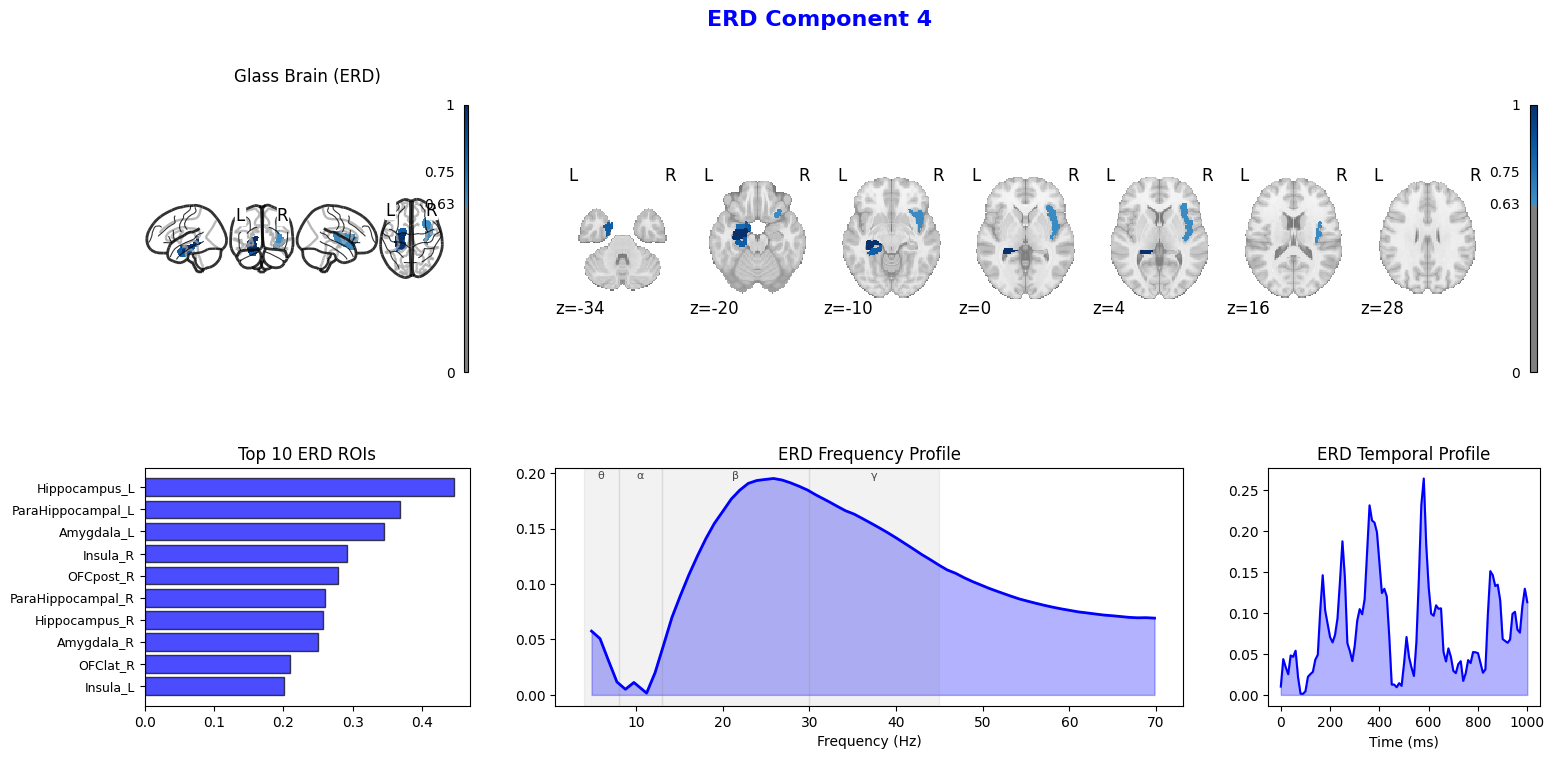

/tmp/ipython-input-2524240269.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


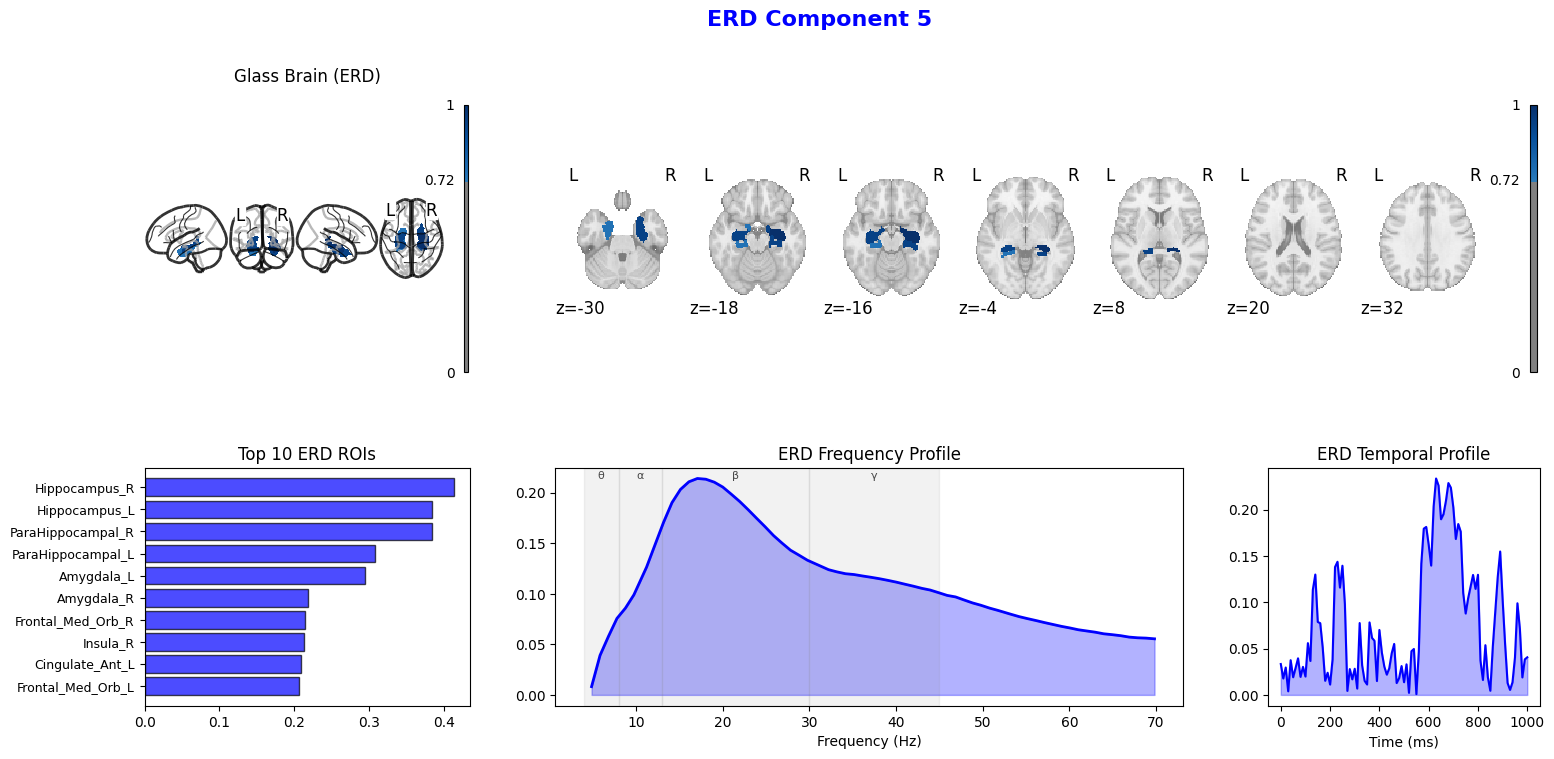

In [87]:
plot_factors_on_atlas(
    A_erd, B_erd, C_erd,
    labels_filtered, aal2_full, aal_nifti_path,
    freq_vec=freq_vec, time_vec=time_vec,
    top_n_rois=10,
    plot_type='ERD',
    save_fig=False,
    filename='ERD'
)

In [ ]:
mat_file = 'TFR_Outcome_ROI_Loss.mat'

with h5py.File(mat_file, 'r') as f:
    tensor_loss = np.array(f['TFR_full'])
    tensor_norm_loss = np.array(f['pow_norm'])
    time_vec = np.array(f['time_vec']).flatten()
    freq_vec = np.array(f['freq_vec']).flatten()
    roi_labels = [''.join(chr(c) for c in f[ref][:].flatten()) for ref in f['roi_labels'][:].flatten()]

print(f"Tensor shape (raw): {tensor_loss.shape}")
print(f"Tensor shape (normalized): {tensor_norm_loss.shape}")
print(f"Time: {time_vec[0]*1000:.0f} to {time_vec[-1]*1000:.0f} ms ({len(time_vec)} points)")
print(f"Freq: {freq_vec[0]:.0f} to {freq_vec[-1]:.0f} Hz ({len(freq_vec)} points)")
print(f"ROIs: {len(roi_labels)}")

Tensor shape (raw): (6,)
Tensor shape (normalized): (101, 42, 120)
Time: 0 to 1000 ms (101 points)
Freq: 4 to 45 Hz (42 points)
ROIs: 120


In [ ]:
tensor_norm_loss = tensor_norm_loss.T

In [ ]:
pow_diff = pow_norm - tensor_norm_loss

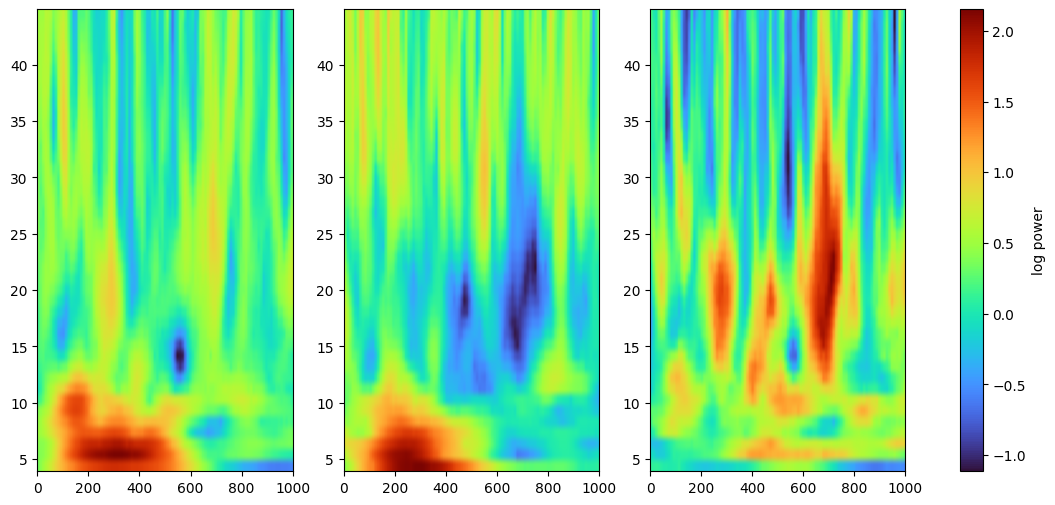

In [ ]:
# Average over trials and ROIs

pow_avg_diff = np.nanmean(pow_diff, axis=(0))
pow_avg_win = np.nanmean(pow_norm, axis=(0))
pow_avg_loss = np.nanmean(tensor_norm_loss, axis=(0))

fig, ax = plt.subplots(1,3,figsize=(14,6))

ax[0].imshow(pow_avg_win, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')

ax[1].imshow(pow_avg_loss, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')

im2 = ax[2].imshow(pow_avg_diff, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')

#plt.xlabel('Time (ms)')
#plt.ylabel('Frequency (Hz)')
#plt.title('TFR (log power, averaged over ROIs)')

fig.colorbar(im2, ax=ax, label='log power')

plt.show()